In [1]:
#requirements
#pip3 install pandas numpy seaborn matplotlib

In [2]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/datasets/onemonthprocessed_nodeload5.csv')
df.set_index(pd.to_datetime(df.ds), drop=True, inplace=True)
df.drop('ds', axis=1, inplace=True)
#df['ds'] = pd.to_datetime(df['ds'], dayfirst=True)
#df = df.drop_duplicates(subset=['ds'], keep='first')
print(df.head(5))
print(df.tail(5))
print(df.describe())
print(df.dtypes)
print(len(df['y']))

                        y
ds                       
2024-05-14 04:37:05  2.90
2024-05-14 04:37:10  2.90
2024-05-14 04:37:15  2.95
2024-05-14 04:37:20  2.95
2024-05-14 04:37:25  2.95
                        y
ds                       
2024-06-13 23:59:40  2.53
2024-06-13 23:59:45  2.56
2024-06-13 23:59:50  2.56
2024-06-13 23:59:55  2.56
2024-06-14 00:00:00  2.56
                   y
count  526471.000000
mean        4.341689
std         2.203016
min         0.860000
25%         2.210000
50%         4.640000
75%         5.990000
max        11.640000
y    float64
dtype: object
526471


/var/folders/bq/b47vvv5n2kxgsnrpx8jqvtqm0000gn/T/ipykernel_1419/1759102513.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.set_index(pd.to_datetime(df.ds), drop=True, inplace=True)


In [4]:
#Let’s check that if the given dataset is stationary or not, For that we use adfuller.
#from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['y'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.84261023779243
p-value: 5.8821742445261216e-12


Test Statistic                -7.842610e+00
p-value                        5.882174e-12
#Lags Used                     1.020000e+02
Number of Observations Used    5.263680e+05
Critical Value (1%)           -3.430362e+00
Critical Value (5%)           -2.861545e+00
Critical Value (10%)          -2.566773e+00
dtype: float64


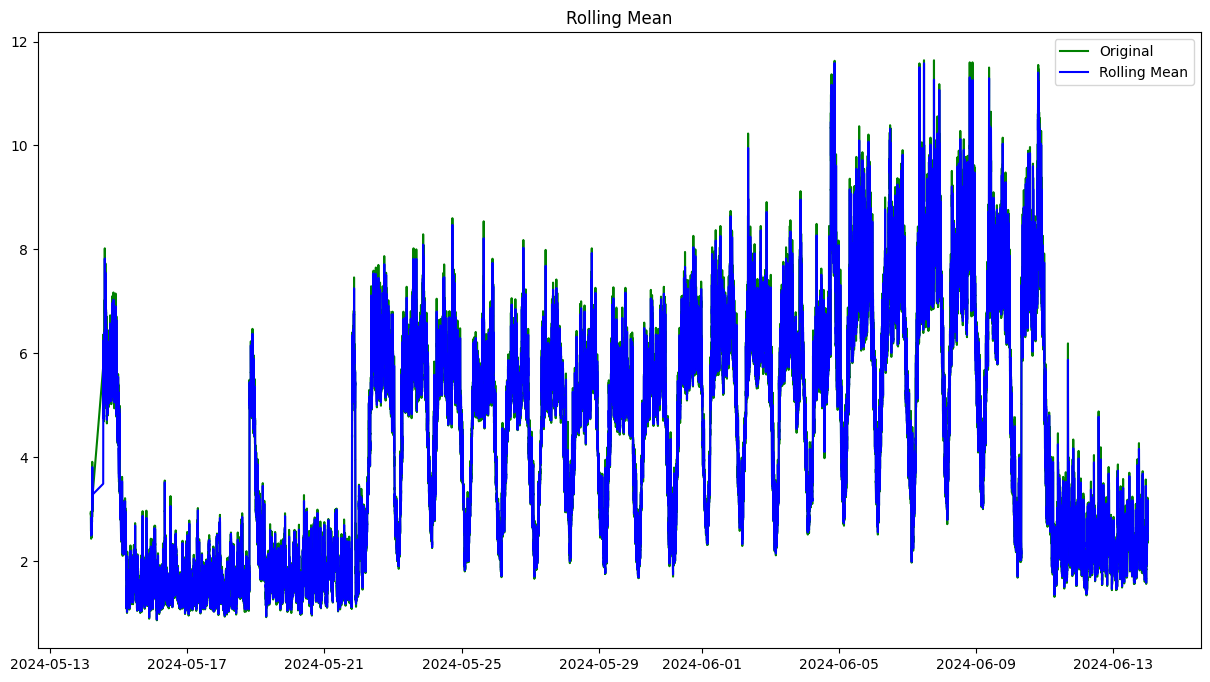

In [5]:
result_output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#print("df_output: \n",result_output)
for key,value in result[4].items():
    result_output['Critical Value (%s)'%key] = value
print(result_output)

# Calculate the rolling mean
roll_mean = df['y'].rolling(12).mean()

# Plot rolling statistics
plt.figure(figsize=(15, 8))
plt.plot(df['y'], color='green', label='Original')
plt.plot(roll_mean, color='blue', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show()

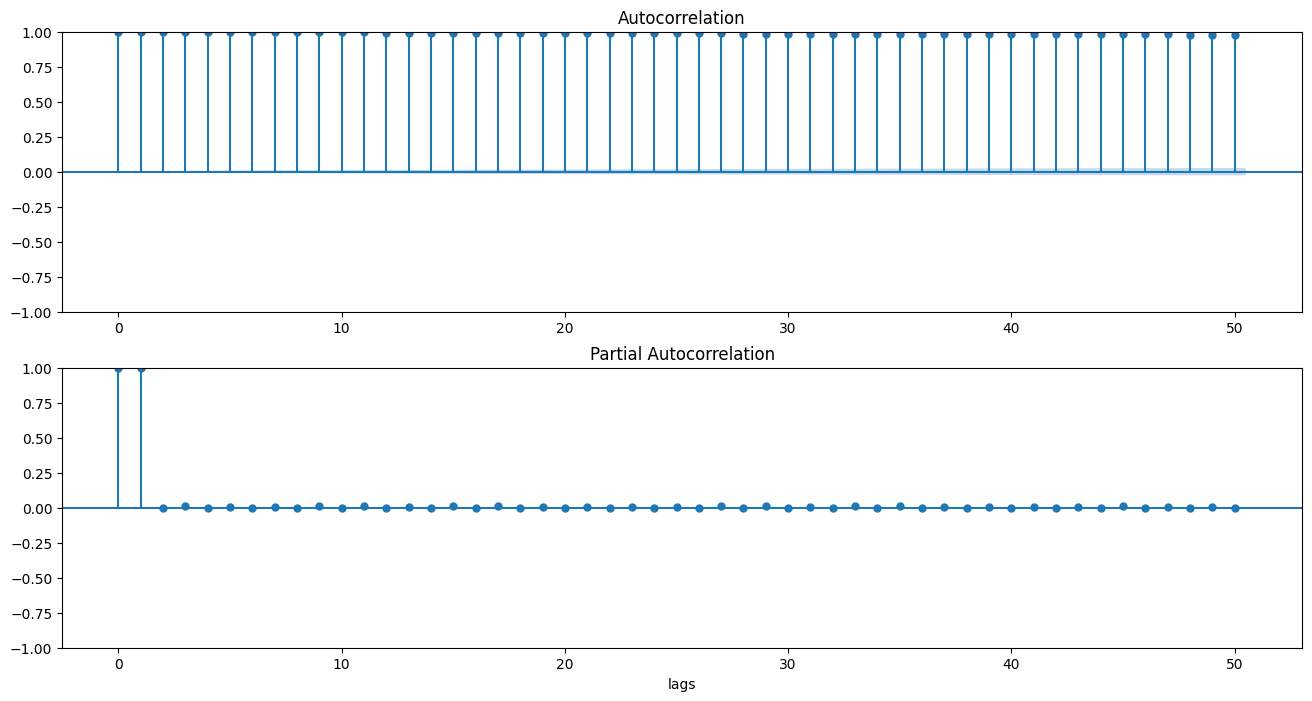

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plt.figure(figsize=(16, 8))
plt.subplot(211)
plot_acf(df['y'], lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(df['y'], lags=50, ax=plt.gca())
plt.xlabel('lags')
plt.show()

**ARIMA**

**Building an ARIMA Model: A Step-by-Step Guide:**
    
    1. Model Definition: Initialize the ARIMA model by invoking ARIMA() and specifying the p, d, and q parameters.
    2. Model Training: Train the model on your dataset using the fit() method.
    3. Making Predictions: Generate forecasts by utilizing the predict() function and designating the desired time index or indices.


In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (example order)
model = ARIMA(df, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               526471
Model:                 ARIMA(1, 1, 1)   Log Likelihood              645785.056
Date:                Sun, 14 Jul 2024   AIC                       -1291564.112
Time:                        12:11:29   BIC                       -1291530.590
Sample:                             0   HQIC                      -1291554.643
                             - 526471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0060      0.067      0.089      0.929      -0.126       0.138
ma.L1         -0.0060      0.067     -0.089      0.929      -0.138       0.126
sigma2         0.0050   1.13e-06   4469.967      0.0

/var/folders/bq/b47vvv5n2kxgsnrpx8jqvtqm0000gn/T/ipykernel_1419/1790419592.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly_data = df.resample('H').mean()


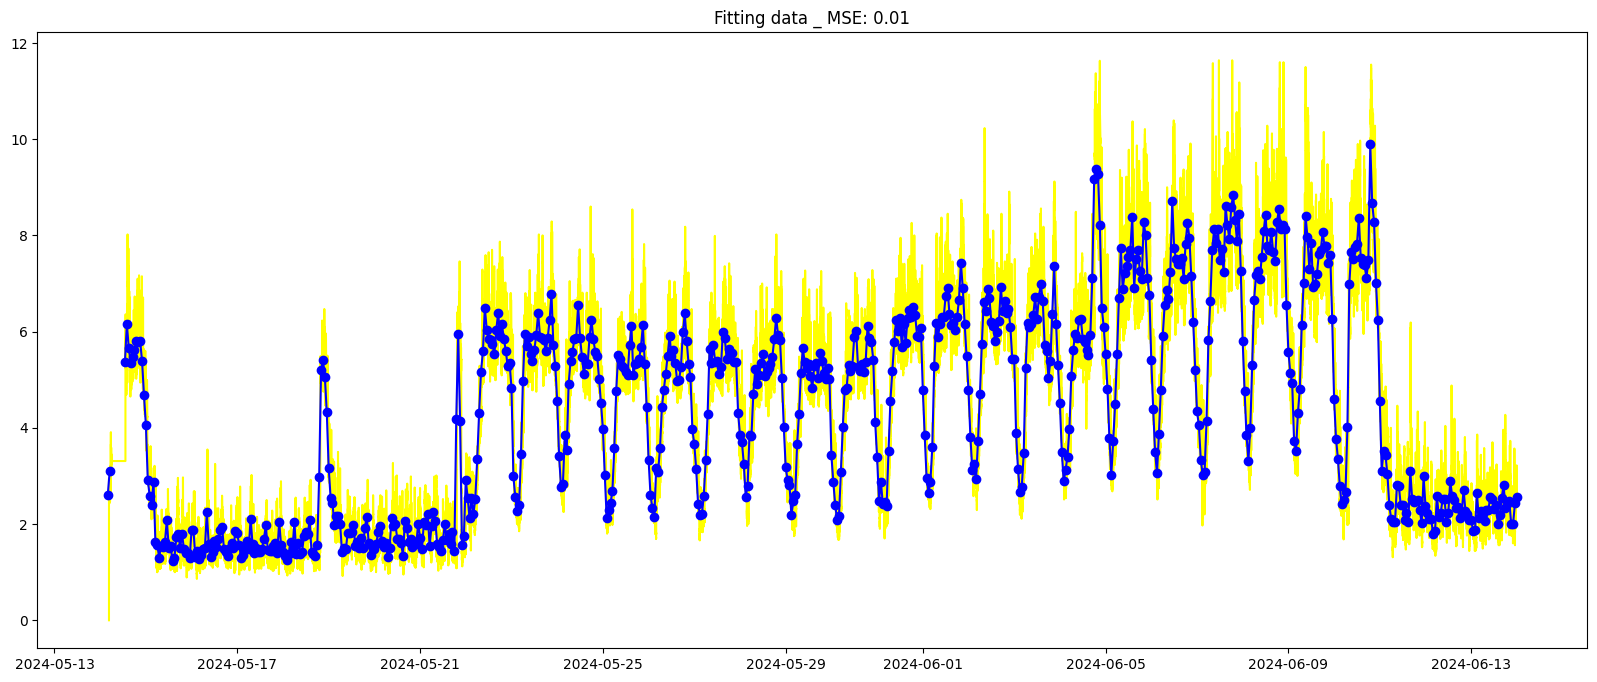

In [8]:
plt.figure(figsize=(20, 8))
#plt.plot(df.y, color='blue',label='Original Data')
plt.plot(model_fit.fittedvalues, color='yellow', label='Fitted Values')
df_hourly_data = df.resample('H').mean()
plt.plot(df_hourly_data.index, df_hourly_data['y'], marker='o', linestyle='-', color='b', label='Hourly Data')
plt.title('Fitting data _ MSE: %.2f'% (((model_fit.fittedvalues-df.y)**2).mean()))
plt.show()

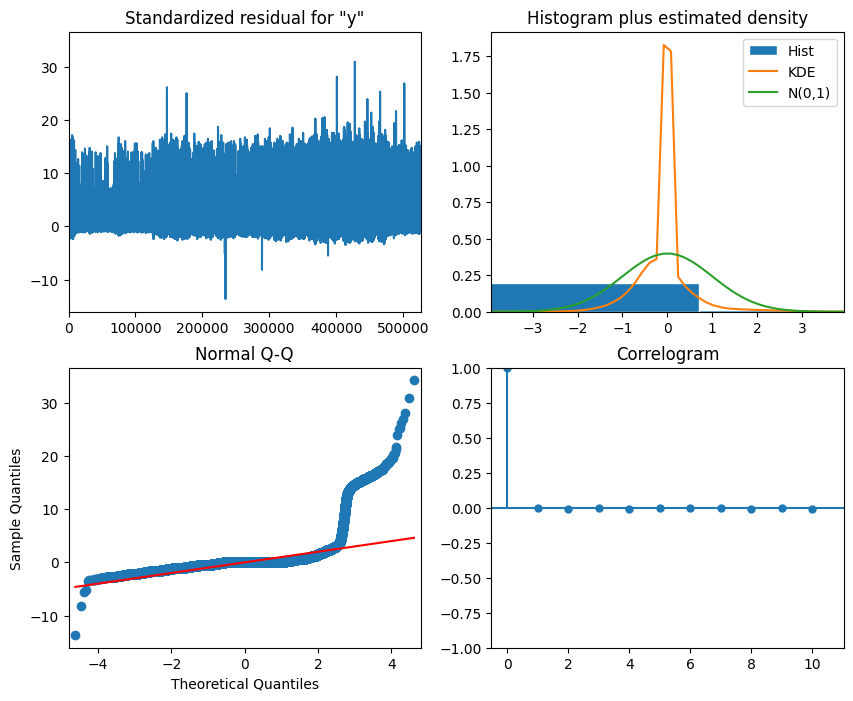

In [9]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

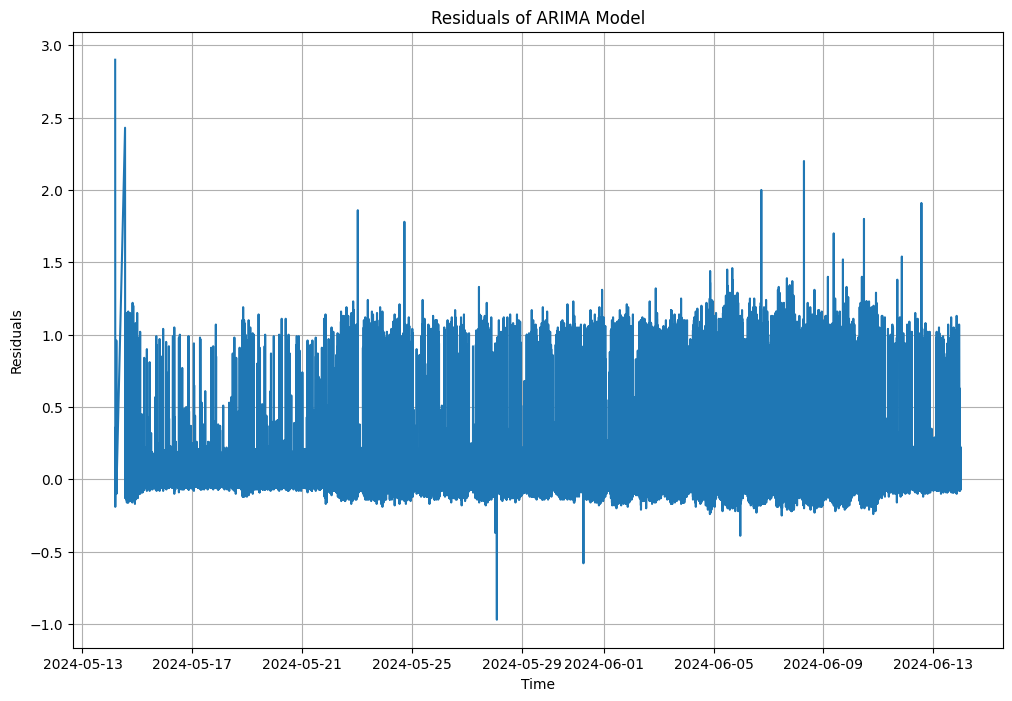

In [10]:
# line plot of residuals
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
plt.figure(figsize=(12, 8))  # Adjust the figsize as per your preference
plt.plot(residuals, label = 'residuals')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

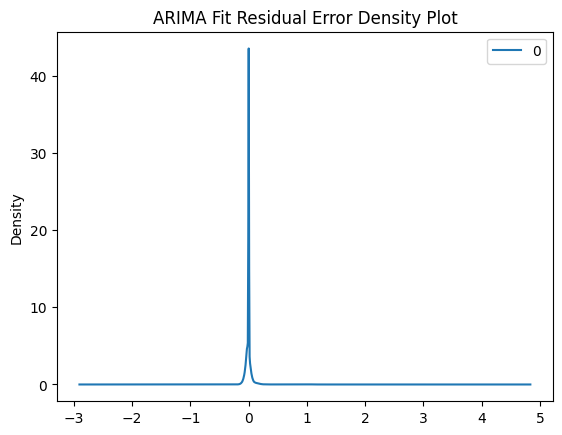

                  0
count  5.264710e+05
mean   4.862567e-06
std    7.107730e-02
min   -9.700000e-01
25%   -1.000000e-02
50%    5.973000e-13
75%    8.275259e-08
max    2.900000e+00


In [11]:
# density plot of residuals
residuals.plot(kind='kde')
plt.title('ARIMA Fit Residual Error Density Plot')
pyplot.show()
print(residuals.describe())
# summary stats of residuals

In [12]:
forecast_steps = 432000 #5days
forecast = model_fit.get_forecast(steps=forecast_steps)
print(forecast)

/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create date range for the forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(seconds=5), periods=forecast_steps, freq='5s')

# Create DataFrame for predictions
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'predicted_mean': forecast_mean,
    'lower_ci': forecast_ci.iloc[:, 0],
    'upper_ci': forecast_ci.iloc[:, 1]
})

# Set date as index
forecast_df.to_csv('../data/predicted/arima_month_forecast_nodeload5.csv', index=False)
forecast_df.set_index('date', inplace=True)
print(forecast_df)

                     predicted_mean   lower_ci   upper_ci
date                                                     
2024-06-14 00:00:05            2.56   2.420912   2.699088
2024-06-14 00:00:10            2.56   2.363299   2.756701
2024-06-14 00:00:15            2.56   2.319091   2.800909
2024-06-14 00:00:20            2.56   2.281823   2.838177
2024-06-14 00:00:25            2.56   2.248988   2.871012
...                             ...        ...        ...
2024-07-08 23:59:40            2.56 -88.858000  93.978000
2024-07-08 23:59:45            2.56 -88.858106  93.978106
2024-07-08 23:59:50            2.56 -88.858212  93.978212
2024-07-08 23:59:55            2.56 -88.858318  93.978318
2024-07-09 00:00:00            2.56 -88.858424  93.978424

[432000 rows x 3 columns]


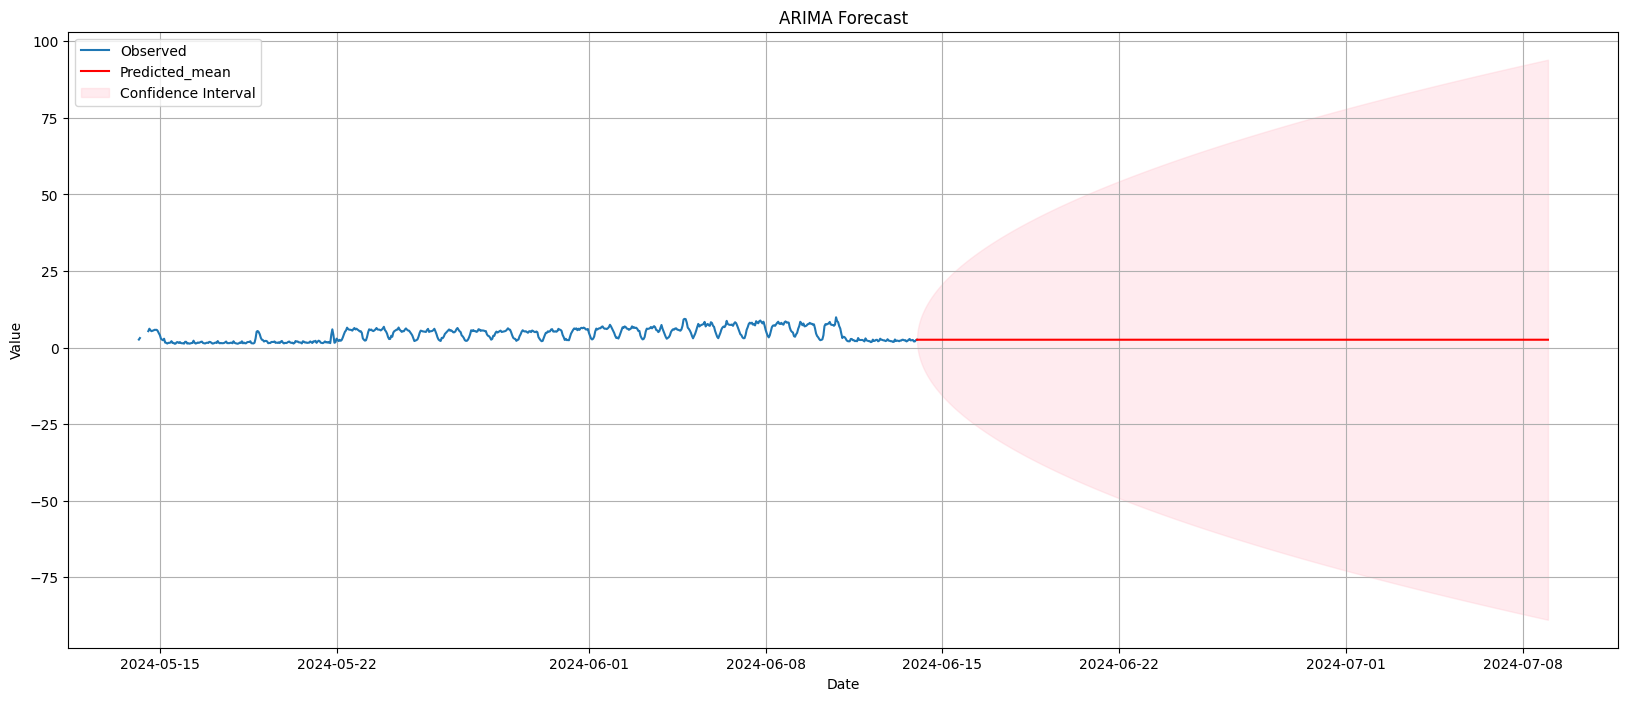

In [14]:
plt.figure(figsize=(20, 8))
df_hourly_data = df.resample('h').mean()
plt.plot(df_hourly_data, label='Observed')  # Plot observed data
plt.plot(forecast_df['predicted_mean'], color='r', label='Predicted_mean')  # Plot forecasted values
plt.fill_between(forecast_df.index, forecast_df['lower_ci'], forecast_df['upper_ci'], color='pink', alpha=0.3, label='Confidence Interval')  # Plot confidence interval
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='date'>

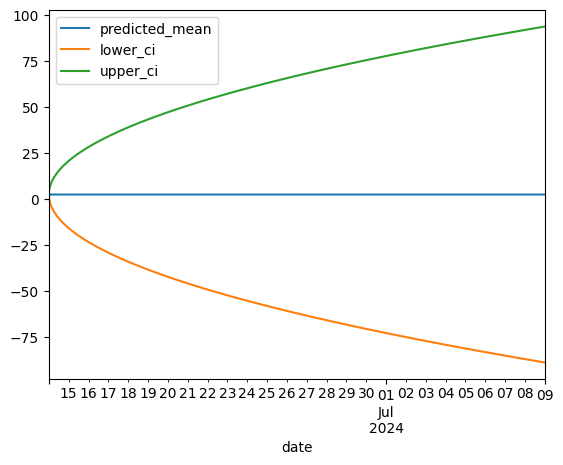

In [15]:
forecast_df.plot()

In [16]:
print(df)
prediction = model_fit.predict('2024-05-14 04:37:05', '2024-06-13 00:00:00')
prediction_df = pd.DataFrame(prediction)
print(prediction_df)

                        y
ds                       
2024-05-14 04:37:05  2.90
2024-05-14 04:37:10  2.90
2024-05-14 04:37:15  2.95
2024-05-14 04:37:20  2.95
2024-05-14 04:37:25  2.95
...                   ...
2024-06-13 23:59:40  2.53
2024-06-13 23:59:45  2.56
2024-06-13 23:59:50  2.56
2024-06-13 23:59:55  2.56
2024-06-14 00:00:00  2.56

[526471 rows x 1 columns]
                     predicted_mean
ds                                 
2024-05-14 04:37:05            0.00
2024-05-14 04:37:10            2.90
2024-05-14 04:37:15            2.90
2024-05-14 04:37:20            2.95
2024-05-14 04:37:25            2.95
...                             ...
2024-06-12 23:59:40            1.97
2024-06-12 23:59:45            1.97
2024-06-12 23:59:50            1.95
2024-06-12 23:59:55            1.95
2024-06-13 00:00:00            1.94

[509190 rows x 1 columns]


In [22]:
prediction_df.to_csv('../data/predicted/arima_month_prediction_nodeload5.csv', index=True)

In [17]:
print(df.describe())
print(prediction_df.describe())

                   y
count  526471.000000
mean        4.341689
std         2.203016
min         0.860000
25%         2.210000
50%         4.640000
75%         5.990000
max        11.640000
       predicted_mean
count   509190.000000
mean         4.411611
std          2.205313
min          0.000000
25%          2.250000
50%          4.810000
75%          6.030000
max         11.640001


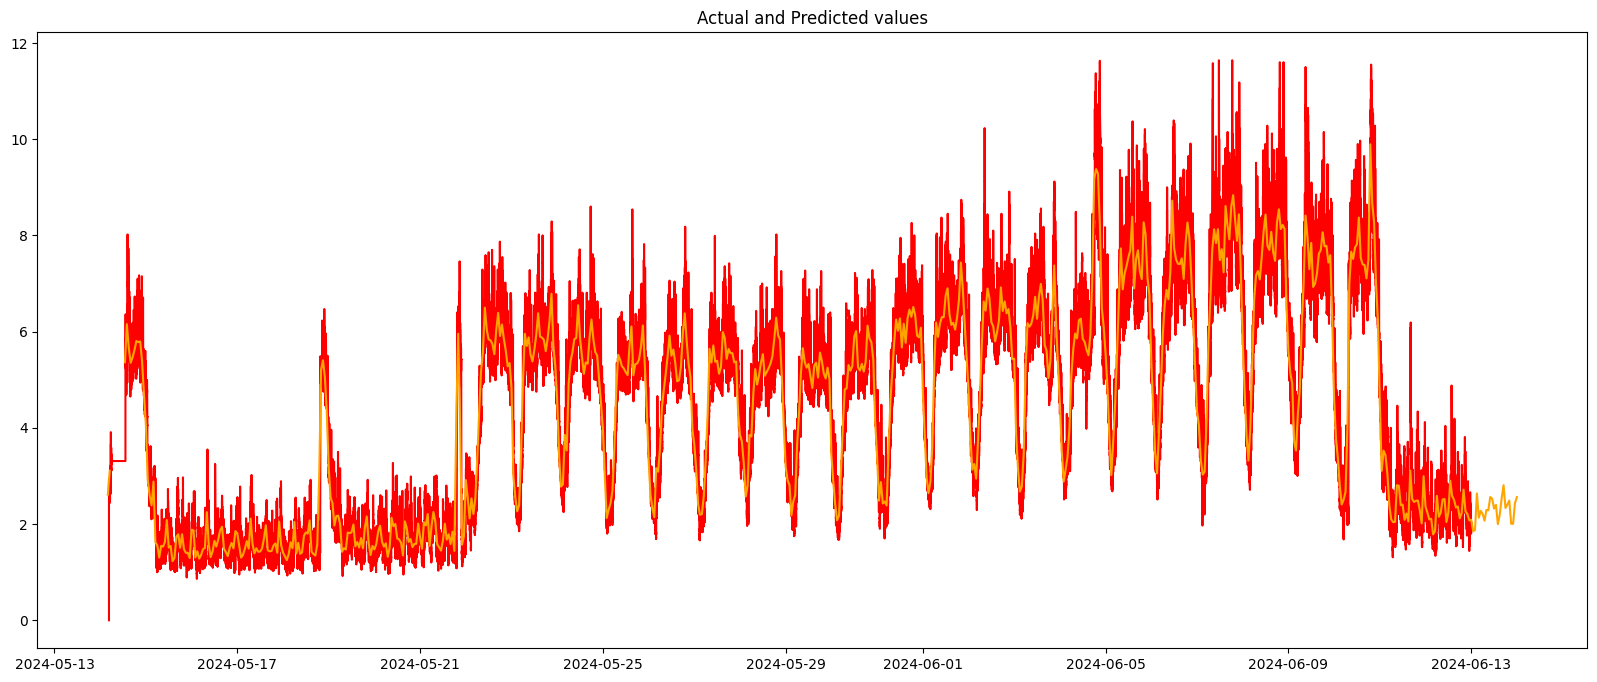

In [18]:
plt.figure(figsize=(20, 8))
#df_hourly_data = df.resample('h').mean()
plt.plot(prediction_df['predicted_mean'], color='red',label='predicted')
plt.plot(df_hourly_data.y, color='orange', label="y")
plt.title('Actual and Predicted values')
plt.show()

NameError: name 'predictions_df' is not defined

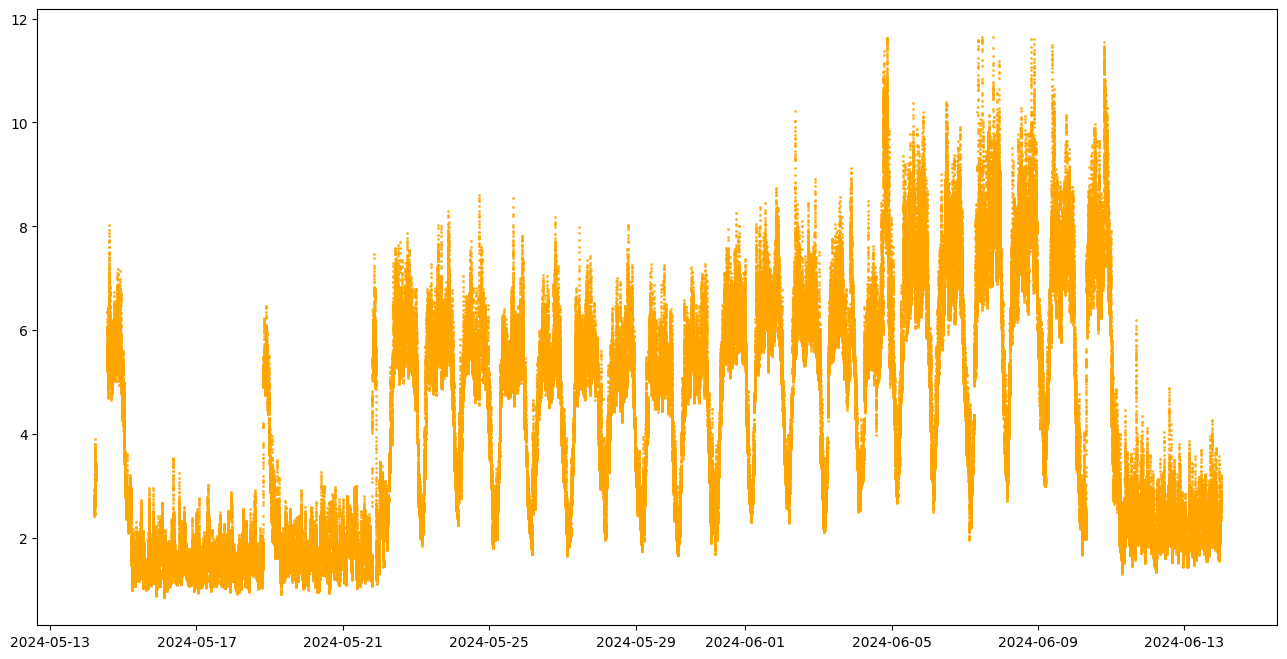

In [19]:
plt.figure(figsize = (16,8))
plt.scatter(df.index, df['y'], color='orange', alpha=0.5, s =1)
plt.scatter(predictions_df.index, predictions_df['predicted_mean'], color='red', alpha=0.5, s =1)
#plt.plot(forecast_df['predicted_mean'], color='r', label='Predicted_mean')

In [ ]:
plt.figure(figsize = (16,8))
plt.scatter(predictions_df.index[:100000], predictions_df['predicted_mean'].head(100000), color='red', alpha=0.5, s =1)
plt.scatter(df.index[:100000], df['y'].head(100000), color='orange', alpha=0.5, s =1)
#plt.plot(forecast_df['predicted_mean'], color='r', label='Predicted_mean')

In [ ]:
predictions_df
def plot(df,df1):
    plt.figure(figsize=(15,5))
    plt.plot(df)
    plt.plot(df1)
    plt.legend(('data', 'predictions'), fontsize=10)
    plt.title("", fontsize=20)
    plt.ylabel('nodeload5', fontsize= 16)
    plt.axhline(0, color= 'r', linestyle= '--', alpha= 0.2)
        
plot(df['y'], predictions_df['predicted_mean'])

In [ ]:
df_hourly_data = df.resample('H').mean()
predictions_df_hourly_data = predictions_df.resample('H').mean()
plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data['y'], marker='o', linestyle='-', color='b', label='Hourly Data')
plt.plot(predictions_df_hourly_data.index, predictions_df_hourly_data['predicted_mean'], marker='o', linestyle='-', color='yellow', label='Hourly Data')
plt.title('Hourly Aggregated Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()